# Mort Subite

## I. Mise en forme de la base de données et chargement des packages

In [2]:
!pip install tslearn
!pip install h5py
!pip install kneed

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans
import seaborn as sns
from sklearn.linear_model import LinearRegression

Nous allons étudier la mort subite.


D'abord, importons nos packages et ouvrons les bases de données

In [4]:
Table_Pop = pd.read_csv('MSTP.csv', sep = ';') #Je réimporte à chaque fois en local la base de données. Je ne stocke pas sur Git car données sensibles 
bd0 = pd.read_csv('MS_BD0.csv', sep = ';', parse_dates=[1])
bd1 = pd.read_csv('MS_BD1.csv', sep = ';', parse_dates=[1])
bd2 = pd.read_csv('MS_BD2.csv', sep = ';', parse_dates=[1])

/tmp/ipykernel_685/3886420623.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bd0 = pd.read_csv('MS_BD0.csv', sep = ';', parse_dates=[1])
/tmp/ipykernel_685/3886420623.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bd1 = pd.read_csv('MS_BD1.csv', sep = ';', parse_dates=[1])
/tmp/ipykernel_685/3886420623.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bd2 = pd.read_csv('MS_BD2.csv', sep = ';', parse_dates=[1])


Je vais concaténer les traitements. 

In [5]:
bdtot = pd.concat([bd0, bd1, bd2])

On va établir une liste des enquêtés pour pouvoir compter leurs soins à l'avenir

In [7]:
list_enq = [] #On crée une liste vide
for elem in Table_Pop['NUM_ENQ']:
    list_enq.append(str(elem))#On ajoute chaque numéro d'enquêté, présent une seule fois sur la table de population

Maintenant, on va chercher à compter combien d'actes de soins ont été reçus par enquêtés. Pour ce faire, nous allons compter les occurences de chaque éléments de la liste dans la base de données totale. On va les implémenter dans la Table Pop ensuite. 

In [8]:
#Création d'un début de dataframe pour remplir boucle
ar = np.array([0, 0]) #Première ligne arbitraire
Nb_Soins = pd.DataFrame(ar) #Conversion de la matrice en DataFrame
Nb_Soins = Nb_Soins.transpose()
Nb_Soins.columns = ['NUM_ENQ', 'NB_SOIN'] #On nomme les colonnes'''
 
#On va maintenant chercher à associer à chaque enquêté le nombre de soin reçu.
#Calcul des soins par personnes et création d'une dataframe qui associe au numéro le nombre de soin
for elem in list_enq:
    c = 0 #Ce sera notre compteur d'itération
    for val in bdtot['NUM_ENQ']:
        if elem==val:
            c = c+1
    ar_temp = np.array([elem, c])
    df_temp = pd.DataFrame(ar_temp)
    df_temp = df_temp.transpose()
    df_temp.columns = ['NUM_ENQ', 'NB_SOIN']
    Nb_Soins = pd.concat([Nb_Soins, df_temp])

Nb_Soins

,NUM_ENQ,NB_SOIN
0,0,0
0,G0-9994,0
0,G0-998,122
0,G0-9977,0
0,G0-9973,0
...,...,...
0,G0-10019,0
0,G0-10018,0
0,G0-10008,6
0,G0-10004,65


In [9]:
#on retire la ligne 0 
Nb_Soins_c = Nb_Soins.copy()
Nb_Soins_c = Nb_Soins_c[Nb_Soins_c['NUM_ENQ']!=0] 

In [10]:
#L'opération ci-dessus étant très longue, on va exporter Nb_Soin pour pas avoir à refaire cette étape. On mettra sur drive la base de données
#Nb_Soins_c.to_excel('Nb_Soins.xlsx')

Nb_Soins_c.to_csv('Nb_Soins.csv')

#Ouvrir la nouvelle dataframe après ré-importation locale 
#Nb_Soins = pd.read_excel('Nb_Soins.xlsx')

In [10]:
#On va joindre la base des soins avec la Table_Pop
Table_Pop = Table_Pop.merge(Nb_Soins_c, on='NUM_ENQ')


In [11]:
Table_Pop['NB_SOIN'] =  Table_Pop['NB_SOIN'].astype(float)

## II. Statistiques descriptives

Ainsi, on peut commencer à effectuer quelques statistiques descriptives

In [38]:
tab1 = Table_Pop.describe()
tab1.to_csv('tableau.csv', index=False)

On peut essayer de comparer avec des variables socio-démographiques. Par exemple, on pourrait penser que les hommes se rendent moins chez le médecin, et donc subissent moins d'actes médicaux, ou sont éventuellement sur-représentés faute de traitement de signe avant coureur. (Pb : Je sais pas si 1 correspond à homme ou femme donc je ne pourrai pas livrer une interprétation de suite)

Autres idées que j'ai pas codé :
- Régression linéraire entre nbr soin et décès
- Lien entre présence de témoins/décès/fait d'être transporté vivant

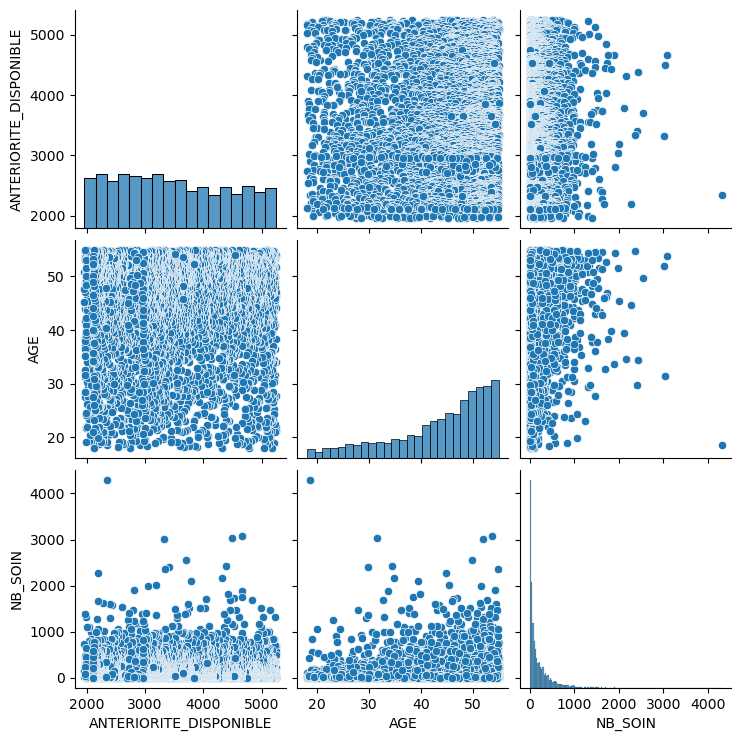

In [17]:
#Pour décrire les variables quanti
Table_Pop_red = Table_Pop.drop(['SEXE', 'CMU', 'AME', 'DECES', 'TYPE_LIEU', 'TEMOIN', 'RCP_TEMOIN', 'ADMIS_VIVANT_HOPITAL', 'RYTHME_CHOQUABLE', 'CORO', 'ANN_EVT', 'TYPE_ASSURANCE'], axis=1)
# on enlève les variables binaires
sns.pairplot(Table_Pop_red, kind = "scatter")
plt.show()

Ici en diagonale on voit la distribution de ces trois variables. L'antériorité disponible est distribuée de manière relativement unifrome, alors qu'on voit une plus forte proportion de personnes plutôt âgées, et plus encore de personnes qui n'ont peu ou pas de consommations de soins. 
Les autres graphiques permettent d'émettre des hypothèses sur les liens entre ces variables. Ici, rien ne ressort, à part un lien entre l'avancée en âge et la consommation de soins. 

<Axes: >

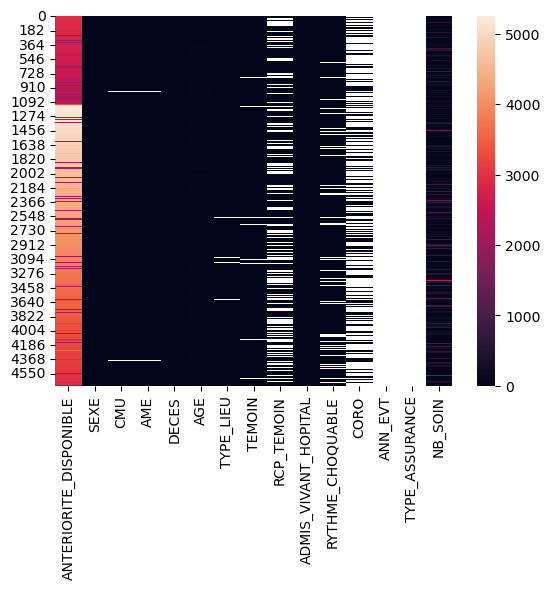

In [28]:
Table_Pop_num = Table_Pop.drop(['NUM_ENQ', 'GROUPE', 'ID_MATCHING', 'DTD_EVT', 'DTD_DCD'], axis=1)
sns.heatmap(Table_Pop_num)
#je sais pas pourquoi ça prend les individus et pas les variables en colonnes

### A. Sexe

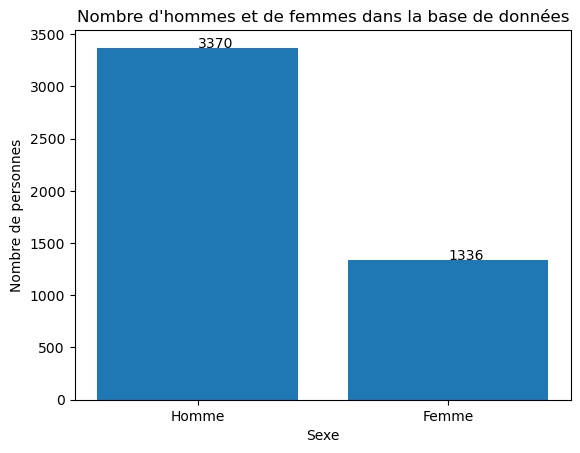

In [11]:
# Compter le nombre de personnes pour chaque sexe
counts = Table_Pop['SEXE'].value_counts()

# Créer un diagramme en barres
positions = range(len(counts))
plt.bar(positions, counts.values)

# Ajouter des étiquettes et un titre
plt.title("Nombre d'hommes et de femmes dans la base de données")
plt.xlabel("Sexe")
plt.ylabel("Effectifs")

# Ajouter des étiquettes pour les catégories
plt.xticks(positions, ['Homme', 'Femme'])

# Ajouter les valeurs des barres
for i, v in enumerate(counts.values):
    plt.text(positions[i], v+0.1, str(v))

# Afficher le diagramme
plt.show()


In [ ]:
#calcul proportion femmes
1336/(3370+1336)

Il y a moins de 30% de femmes dans la base de données. Les hommes sont donc 2.5 fois plus sujets à la mort subite.

In [29]:
df_0 = Table_Pop[Table_Pop['SEXE']==0.0]
df_1 = Table_Pop[Table_Pop['SEXE']==1.0]

df_0.describe()
df_1.describe()

,ANTERIORITE_DISPONIBLE,SEXE,CMU,AME,DECES,AGE,TYPE_LIEU,TEMOIN,RCP_TEMOIN,ADMIS_VIVANT_HOPITAL,RYTHME_CHOQUABLE,CORO,ANN_EVT,TYPE_ASSURANCE,NB_SOIN
count,3370.000000,3370.0,3355.000000,3355.000000,3370.000000,3370.000000,3362.000000,3329.000000,2295.000000,3370.000000,3048.000000,1426.000000,0.0,0.0,3370.000000
mean,3488.746884,1.0,0.134426,0.019970,0.876558,44.101619,0.401844,0.676479,0.657952,0.389614,0.331693,0.535764,NaN,NaN,158.344510
std,939.952288,0.0,0.341161,0.139919,0.328993,9.174864,0.490344,0.467890,0.474499,0.487735,0.470899,0.498894,NaN,NaN,235.080725
min,1961.000000,1.0,0.000000,0.000000,0.000000,18.015428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,2680.500000,1.0,0.000000,0.000000,1.000000,39.442973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,17.000000
50%,3395.000000,1.0,0.000000,0.000000,1.000000,46.807258,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,NaN,NaN,64.000000
75%,4313.750000,1.0,0.000000,0.000000,1.000000,51.316591,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,208.000000
max,5248.000000,1.0,1.000000,1.000000,1.000000,54.996338,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,2550.000000


In [17]:
Table_Pop['AGE_CAT'] = pd.cut(Table_Pop['AGE'], bins =  [18, 30, 40, 50, 55])

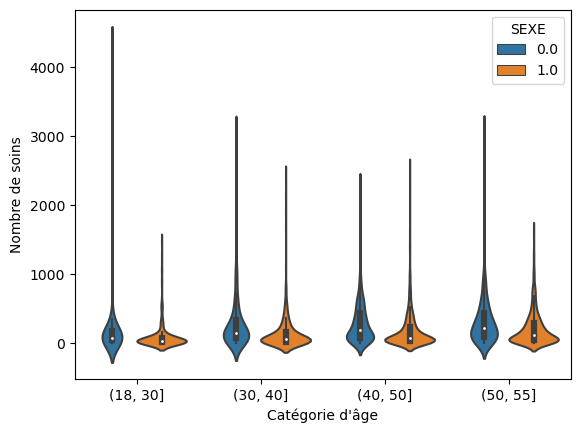

In [106]:
sns.violinplot(x=Table_Pop["AGE_CAT"], y=Table_Pop["NB_SOIN"], hue=Table_Pop["SEXE"])

# Ajouter une étiquette à l'axe des x
plt.xlabel('Catégorie d\'âge')

# Ajouter une étiquette à l'axe des y
plt.ylabel('Nombre de soins')

# Afficher le graphique
plt.show()


On voit que le nombre médian de soins consommés est plus important pour les femmes à tout âge, en bleu, mais il est également plus variable, sauf pour les quarantenaires. La différence de variance est beaucoup plus importante pour les jeunes, entre 18 et 30 ans. 

### B. Âge

/tmp/ipykernel_135/3046688039.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=Table_Pop["AGE"], hist=True, kde=True, rug=False)


<Axes: xlabel='AGE', ylabel='Density'>

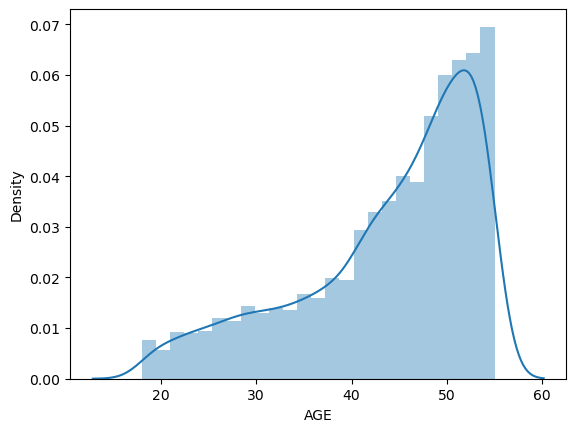

In [40]:
#sns.distplot(a=Table_Pop["AGE"], hist=True, kde=True, rug=False)


In [ ]:
## Ridgeline : marche pas
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
Table_Pop['mean_AGE'] = Table_Pop['AGE'].map(Table_Pop.groupby('AGE')['NB_SOIN'].mean())
g = sns.FacetGrid(Table_Pop, row="AGE", hue="mean_AGE", aspect=15, height=.5, palette=pal)

# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=12)

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(Table_Pop, row='AGE', hue='mean_AGE', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'mean_AGE',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'Mean_AGE', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)
    
# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.3)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Temperature in degree Celsius', fontweight='bold', fontsize=15)
g.fig.suptitle('Daily average temperature in Seattle per month',
               ha='right',
               fontsize=20,
               fontweight=20)

plt.show()



### C. CMU

In [ ]:
#Combien d'hommes et de femmes?
plt.hist(Table_Pop['CMU'])
plt.title("Nombre de personnes bénéficiant ou non de la CMU dans la base de données")
plt.xlabel("CMU")
plt.ylabel("Nombre de personnes")

# Compter le nombre de personnes pour chaque sexe
counts = Table_Pop['CMU'].value_counts()

# Créer un diagramme en barres
positions = range(len(counts))
plt.bar(positions, counts.values)

# Ajouter des étiquettes et un titre
plt.title("Nombre de personnes bénéficiant ou non de la CMU dans la base de données")
plt.xlabel("CMU")
plt.ylabel("Effectifs")

# Ajouter des étiquettes pour les catégories
plt.xticks(positions, ['Bénéficiaire', 'Non bénéficiaire'])

# Ajouter les valeurs des barres
for i, v in enumerate(counts.values):
    plt.text(positions[i], v+0.1, str(v))

# Afficher le diagramme
plt.show()


Ici ce serait bien d'avoir les chiffres exacts pour calculer un pourcentage (comme pour le sexe plus haut).

<Axes: xlabel='AGE_CAT', ylabel='NB_SOIN'>

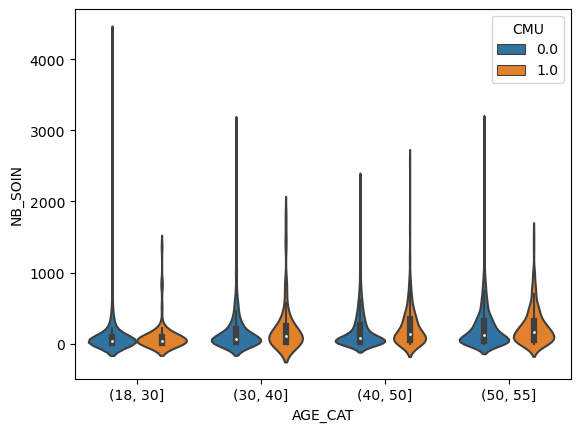

In [52]:
sns.violinplot(x=Table_Pop["AGE_CAT"], y=Table_Pop["NB_SOIN"], hue=Table_Pop["CMU"])

Chez les plus jeunes, les différences entre bénéficiaires de la CMU ou non sont assez faibles. Avec l'âge, les médianes s'écartent, ave une consommation de soins plus importante chez les personnes bénéficiaires de la CMU.

### Description temporelle


Cependant, nous perdons l'aspect temporel avec cette manière de décrire, il faudrait indexer par les jours la fréquence de soins pour avoir une idée de leur comportement dans le temps

On va donc essayer de déterminer le nombre de soins à l'approche de la date, en faisant des variables catégorielles pour ensuite représenter un histogramme. On se servira de bdtot. Idées sur : https://ichi.pro/fr/statistiques-de-base-pour-l-analyse-des-series-temporelles-en-python-84324298089781

In [6]:
bdtot['DIFF_DAY'] = bdtot['DIFF_DAY'].astype(np.float64)

ValueError: Plotly Express cannot process wide-form data with columns of different type.

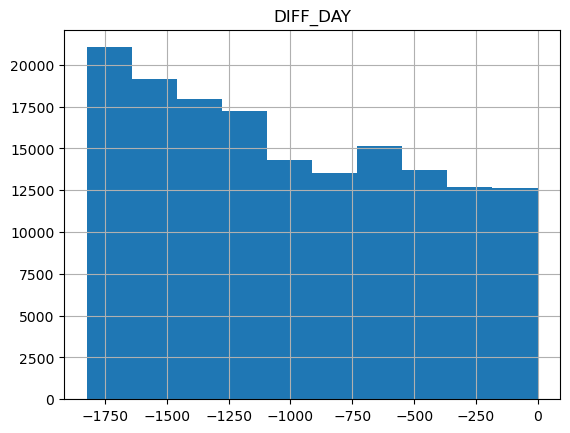

In [20]:
bdtot.hist()
import plotly.express as px
fig = px.bar(bdtot, barmode = 'stack')
#Ici ce serait pas mal de faire un graphique empilé avec des couleurs selon le type de conso de soins (hospitalière avec un code commençant par PMSI, pharmaceutique avec un code commençant par PHA)

In [21]:
q1 = bdtot['DIFF_DAY'].quantile(0.1)
q2 = bdtot['DIFF_DAY'].quantile(0.2)
q3 = bdtot['DIFF_DAY'].quantile(0.3)
q4 = bdtot['DIFF_DAY'].quantile(0.4)
q5 = bdtot['DIFF_DAY'].quantile(0.5)
q6 = bdtot['DIFF_DAY'].quantile(0.6)
q7 = bdtot['DIFF_DAY'].quantile(0.7)
q8 = bdtot['DIFF_DAY'].quantile(0.8)
q9 = bdtot['DIFF_DAY'].quantile(0.9)

df1 = bdtot[bdtot['DIFF_DAY']<q1] #Premier décile
df2 = bdtot[bdtot['DIFF_DAY']>=q1] 
df2 = df2[df2['DIFF_DAY']<q2] #Deuxième décile
df3 = bdtot[bdtot['DIFF_DAY']>=q2] 
df3 = df3[df3['DIFF_DAY']<q3]
df4 = bdtot[bdtot['DIFF_DAY']>=q3] 
df4 = df4[df4['DIFF_DAY']<q4]
df5 = bdtot[bdtot['DIFF_DAY']>=q4] 
df5 = df5[df5['DIFF_DAY']<q5]
df6 = bdtot[bdtot['DIFF_DAY']>=q5] 
df6 = df6[df6['DIFF_DAY']<q6]
df7 = bdtot[bdtot['DIFF_DAY']>=q6] 
df7 = df7[df7['DIFF_DAY']<q7]
df8 = bdtot[bdtot['DIFF_DAY']>=q7] 
df8 = df8[df8['DIFF_DAY']<q8]
df9 = bdtot[bdtot['DIFF_DAY']>=q8] 
df9 = df9[df9['DIFF_DAY']<q9]
df10 = bdtot[bdtot['DIFF_DAY']>=q9]

In [22]:
listedf = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
diag = []
medic = []
for elem in listedf:
    cdiag = 0
    cmedic = 0
    for i in range(elem.shape[0]):
        if elem['NIVEAU_1'].values[i].startswith('PHA')==True:
            cmedic = cmedic+1
        else:
            cdiag = cdiag+1
    diag.append(cdiag)
    medic.append(cmedic)

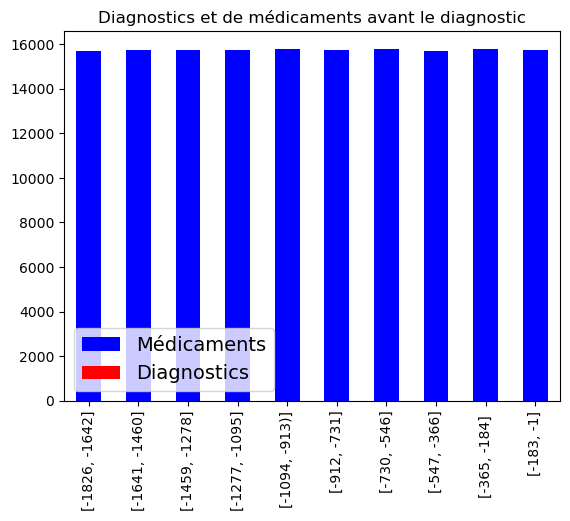

In [23]:
dfbar = pd.DataFrame(dict(Medic=medic, Diagnostics=diag))
dfbar = dfbar.rename(index={0:'[-1826, -1642]',1:'[-1641, -1460]',2:'[-1459, -1278]',3:'[-1277, -1095]',4:'[-1094, -913)]',5:'[-912, -731]',6:'[-730, -546]',7:'[-547, -366]',8:'[-365, -184] ',9:'[-183, -1]'})
ax = dfbar.plot.bar(stacked=True, color=['blue', 'red'])
plt.title("Diagnostics et de médicaments avant le diagnostic")
h,l = ax.get_legend_handles_labels()
ax.legend(h[:3],["Médicaments", "Diagnostics"], loc=3, fontsize=14)
plt.show()

Nous allons donc créer des catégories à partir de ces valeurs.

In [ ]:
bdtot_c = bdtot.copy()
bdtot_c['DIFF_DAY'] = pd.cut(bdtot_c['DIFF_DAY'], 10)
bdtot_c['DIFF_DAY'].sample(20)

In [ ]:
ar = np.array([0, 0]) #Première ligne arbitraire
Nb_Soins = pd.DataFrame(ar) #Conversion de la matrice en DataFrame
Nb_Soins = Nb_Soins.transpose()
Nb_Soins.columns = ['TPS', 'NB_SOIN'] #On nomme les colonnes'''
liste = list(set(list(bdtot_c['DIFF_DAY'])))


 
#On va maintenant chercher à associer à chaque enquêté le nombre de soin reçu.
#Calcul des soins par personnes et création d'une dataframe qui associe au numéro le nombre de soin
for elem in liste:
    c = 0 #Ce sera notre compteur d'itération
    for val in bdtot_c['DIFF_DAY']:
        if elem==val:
            c = c+1
    ar_temp = np.array([elem, c])
    df_temp = pd.DataFrame(ar_temp)
    df_temp = df_temp.transpose()
    df_temp.columns = ['TPS', 'NB_SOIN']
    Nb_Soins = pd.concat([Nb_Soins, df_temp])

Nb_Soins

In [ ]:
Nb_Soins_c = Nb_Soins.copy()
Nb_Soins_c = Nb_Soins_c[Nb_Soins_c['TPS']!=0] 

## III. Modélisation : Clustering de séries temporelles**

On va appliquer l'algorithme des k-means pour établir des clusters (et donc des profils de patient). Cependant, ayant entre les mains une série temporelle, nous n'allons pas utiliser une distance euclidienne classique mais la "Dynamic Time Warping Distance" qui est plus adaptée au type de données qu'on traite. En effet, la distance euclidienne ne permet pas d'absorber l'aspect temporel des données.

Nous partirons de la base de données qui *expliquer*

*Génération de la base de données du clustering*

On va utiliser une base de données qui contient le nombre de soins consommés par mois par enquêtés pour avoir des valeurs quantitatives

In [7]:
bdtot = bdtot.drop(axis = 0, index=17427) #S ça affche erreur osef, juste une fos j'ai eu une ligne en trop

In [8]:
bdtot['DIFF_MONTH'] = np.round(bdtot['DIFF_DAY'] / 30 -1).astype(int) #On indexe le temps par mois précédent l'accident

In [9]:
# Grouper les données par enquêté et par mois
gb = bdtot.groupby(['NUM_ENQ', 'DIFF_MONTH'])

# Compter le nombre de soins dans chaque groupe
counts = gb.size().reset_index(name='NB_SOINS')

# Pivoter les données pour obtenir une colonne par mois
df_cl1 = counts.pivot(index='NUM_ENQ', columns='DIFF_MONTH', values='NB_SOINS')

# Remplacer les valeurs manquantes par 0
df_cl1.fillna(0, inplace=True)

# Renommer les colonnes pour ajouter le préfixe 'mois_'
df_cl1.columns = [f'mois_{col}' for col in df_cl1.columns]

df_cl1

,mois_-62,mois_-61,mois_-60,mois_-59,mois_-58,mois_-57,mois_-56,mois_-55,mois_-54,mois_-53,...,mois_-10,mois_-9,mois_-8,mois_-7,mois_-6,mois_-5,mois_-4,mois_-3,mois_-2,mois_-1
NUM_ENQ,,,,,,,,,,,,,,,,,,,,,
G0-10001,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
G0-10004,0.0,6.0,10.0,1.0,0.0,5.0,8.0,6.0,4.0,4.0,...,29.0,0.0,1.0,3.0,4.0,0.0,1.0,3.0,4.0,7.0
G0-10008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
G0-10018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0-10019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G0-9968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,2.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
G0-9970,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
G0-9973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
#on ajoute les manquants de bdtot

enquetes_soin = df_cl1.index.tolist()

# Créer une liste de tous les enquêtés dans Table_Pop
tous_enquetes = Table_Pop["NUM_ENQ"].tolist()

# Créer une liste des enquêtés qui n'ont pas reçu de soins
enquetes_sans_soin = list(set(tous_enquetes) - set(enquetes_soin))

# Ajouter les enquêtés sans soin dans df_cl1 avec 0 soin pour chaque mois
for enquete in enquetes_sans_soin:
    df_cl1.loc[enquete] = 0

df_cl1

,mois_-62,mois_-61,mois_-60,mois_-59,mois_-58,mois_-57,mois_-56,mois_-55,mois_-54,mois_-53,...,mois_-10,mois_-9,mois_-8,mois_-7,mois_-6,mois_-5,mois_-4,mois_-3,mois_-2,mois_-1
NUM_ENQ,,,,,,,,,,,,,,,,,,,,,
G0-10001,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
G0-10004,0.0,6.0,10.0,1.0,0.0,5.0,8.0,6.0,4.0,4.0,...,29.0,0.0,1.0,3.0,4.0,0.0,1.0,3.0,4.0,7.0
G0-10008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
G0-10018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0-10019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G0-5033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0-35629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G0-33676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_cl = df_cl1.copy()

Nous allons estimer cela en ayant recours à la méthode "silhouette coefficient". Ce coefficient calcule à quel point les points d'un même cluster sont proches entre eux et à quel point ces points sont bien éloignés des autres clusters. On va donc le calculer pour un certain nombre de cluster afin de déterminer le nombre idéal à générer : ce nombre sera celui qui maximise le coefficient. 

On va choisir un nombre de cluster qui maximise le coefficient de Silhouette. On s'aperçoit en lisant la liste que le nombre optimal semble être 2 clusters.

In [ ]:
#Pas besoin de lancer cette cellule quand tu reprends le doc Clémence. 

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = TimeSeriesKMeans(n_clusters=k,metric="dtw", max_iter=10)
    kmeans.fit(df_cl)
    score = silhouette_score(df_cl, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients 

*k-means*

In [12]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
a = model.fit(df_cl)
a

TimeSeriesKMeans(max_iter=10, metric='dtw')

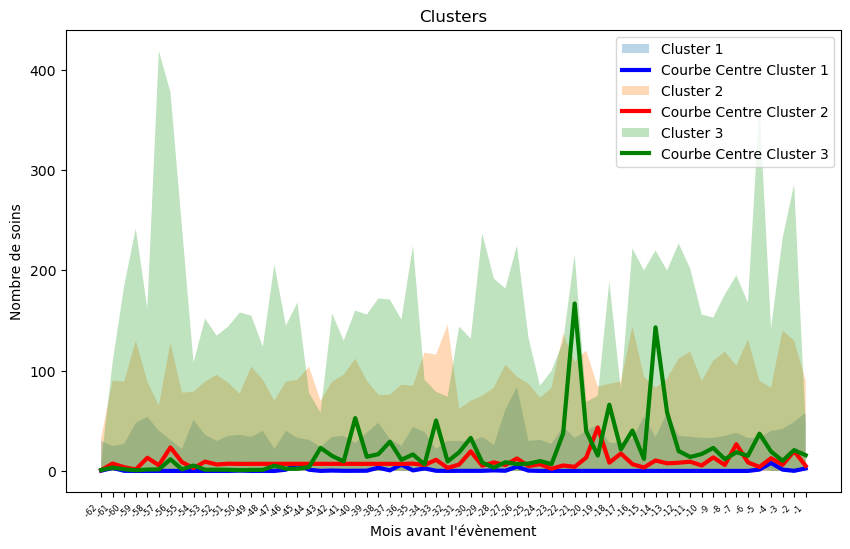

In [13]:
# Extraire les labels de cluster pour chaque série temporelle
labels = model.labels_

# Obtenir les centres des clusters
centroids = model.cluster_centers_

# Afficher les patates avec des points
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(model.n_clusters):
    # Extraire les séries temporelles appartenant au cluster i
    cluster_i = df_cl[labels == i]
    # Calculer les limites supérieure et inférieure de chaque patate
    lower = np.min(cluster_i.values, axis=0)
    upper = np.max(cluster_i.values, axis=0)
    # Tracer chaque patate avec des points et ajouter la légende
    if i == 0:
        ax.fill_between(range(len(lower)), lower, upper, alpha=0.3, label=f'Cluster {i+1}')
        ax.plot(centroids[i], '-b', linewidth=3, label='Courbe Centre Cluster 1')
    elif i == 1:
        ax.fill_between(range(len(lower)), lower, upper, alpha=0.3, label=f'Cluster {i+1}')
        ax.plot(centroids[i], '-r', linewidth=3, label='Courbe Centre Cluster %d' % (i+1))
    else:
        ax.fill_between(range(len(lower)), lower, upper, alpha=0.3, label=f'Cluster {i+1}')
        ax.plot(centroids[i], '-g', linewidth=3, label='Courbe Centre Cluster %d' % (i+1))

# Définir les étiquettes de l'axe des x en utilisant les mois négatifs
months = ['-{} '.format(abs(i)) for i in reversed(range(1, 63))]
plt.xticks(range(len(months)), months)
ax.set_xticklabels(months, rotation=45, ha='right', fontsize=6)

# Afficher la légende avec les noms des courbes
ax.legend()

# Modifier les étiquettes d'axes
ax.set_title('Clusters')
ax.set_xlabel('Mois avant l\'évènement')
ax.set_ylabel('Nombre de soins')
ax.legend(loc='best')
plt.show()

In [15]:
fig.savefig('Cluster.png')

In [16]:
clus = a.predict(df_cl)
clus



/opt/mamba/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4706 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


array([0, 1, 0, ..., 0, 0, 0])

In [17]:
print("Nombre d'itérations :", model.n_iter_)
print("Étiquettes de cluster :", model.labels_)
print("Somme des distances intra-cluster :", model.inertia_)
print("Distance moyenne entre les séries temporelles et leur centre de cluster :", model.score(df_cl))

Nombre d'itérations : 6
Étiquettes de cluster : [0 1 0 ... 0 0 0]
Somme des distances intra-cluster : 937.5060695074068


AttributeError: 'TimeSeriesKMeans' object has no attribute 'score'

In [18]:
# Utiliser les étiquettes de cluster pour indexer le dataframe
df_clusters = df_cl.assign(cluster=model.labels_)
#Ajouter les vars sociodémo
df_clusters = df_clusters.merge(Table_Pop, on='NUM_ENQ')

IndexError: single positional indexer is out-of-bounds

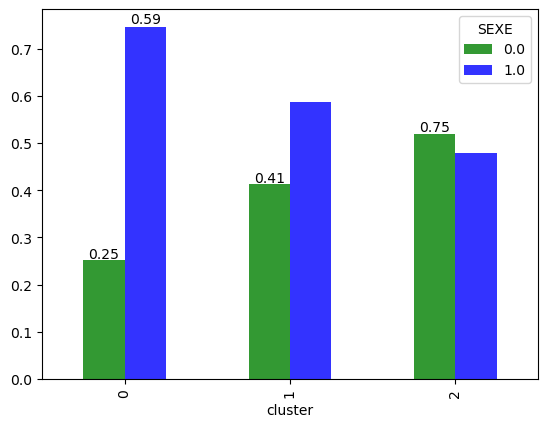

In [19]:
# Calculer les statistiques descriptives pour chaque groupe
clus_sexe = df_clusters.groupby("cluster")["SEXE"].value_counts(normalize=True)

# Convertisser l'objet pandas en un dataframe pour faciliter la manipulation
df_stats = clus_sexe.unstack().fillna(0)

# Tracer le graphique
ax = df_stats.plot(kind="bar", color=["green", "blue"], alpha=0.8)

# Ajouter les proportions exactes sur les barres
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    width, height = patch.get_width(), patch.get_height()
    label = "{:.2f}".format(df_stats.iloc[:, i // 2].values[i % 2])
    ax.text(x + width/2, y + height*1.01, label, ha="center")

# Personnaliser les étiquettes et la légende
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
ax.set_xticklabels(["Cluster 1", "Cluster 2"], rotation=0)
ax.legend(["Femme", "Homme"])

plt.show()



IndexError: single positional indexer is out-of-bounds

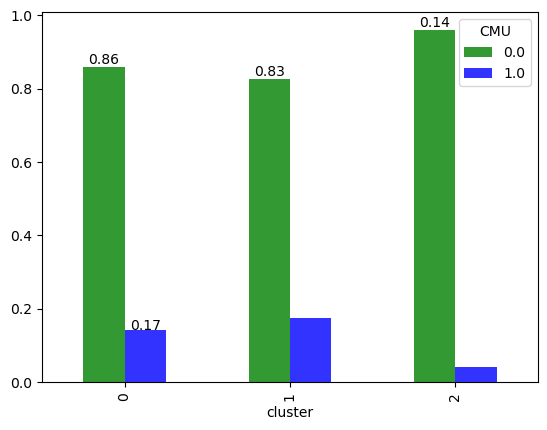

In [20]:

# Calculer les statistiques descriptives pour chaque groupe
clus_CMU = df_clusters.groupby("cluster")["CMU"].value_counts(normalize=True)

# Convertisser l'objet pandas en un dataframe pour faciliter la manipulation
df_stats = clus_CMU.unstack().fillna(0)

# Tracer le graphique
ax = df_stats.plot(kind="bar", color=["green", "blue"], alpha=0.8)

# Ajouter les proportions exactes sur les barres
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    width, height = patch.get_width(), patch.get_height()
    label = "{:.2f}".format(df_stats.iloc[:, i // 2].values[i % 2])
    ax.text(x + width/2, y + height*1.01, label, ha="center")

# Personnaliser les étiquettes et la légende
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
ax.set_xticklabels(["Cluster 1", "Cluster 2", "Cluster 3"], rotation=0)
ax.legend(["Bénéficiaire", "Non bénéficiaire"])

plt.show()


IndexError: single positional indexer is out-of-bounds

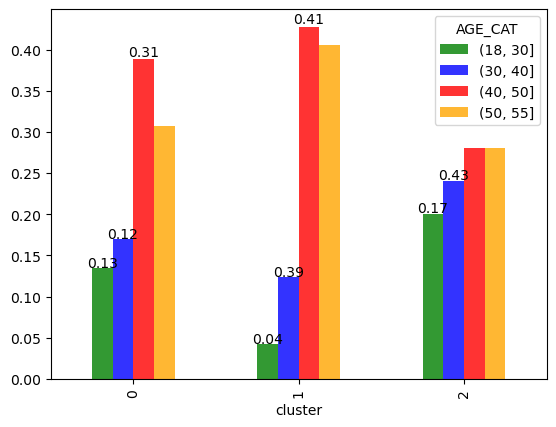

In [21]:
df_clusters['AGE_CAT'] = pd.cut(df_clusters['AGE'], bins =  [18, 30, 40, 50, 55])
# Calculer les statistiques descriptives pour chaque groupe
clus_age = df_clusters.groupby("cluster")["AGE_CAT"].value_counts(normalize=True)

# Convertisser l'objet pandas en un dataframe pour faciliter la manipulation
df_stats = clus_age.unstack().fillna(0)

# Tracer le graphique
ax = df_stats.plot(kind="bar", color=["green", "blue", "red", "orange"], alpha=0.8)

# Ajouter les proportions exactes sur les barres
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    width, height = patch.get_width(), patch.get_height()
    label = "{:.2f}".format(df_stats.iloc[:, i // 2].values[i % 2])
    ax.text(x + width/2, y + height*1.01, label, ha="center")

# Personnaliser les étiquettes et la légende
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
ax.set_xticklabels(["Cluster 1", "Cluster 2", "Cluster 3"], rotation=0)
ax.legend(["18 à 30 ans", "30 à 40 ans", "40 à 50 ans", "50 à 55 ans"])

plt.show()

IndexError: single positional indexer is out-of-bounds

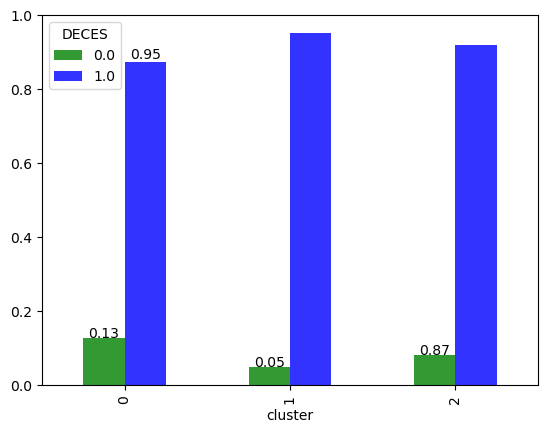

In [22]:
# Calculer les statistiques descriptives pour chaque groupe
clus_deces = df_clusters.groupby("cluster")["DECES"].value_counts(normalize=True)

# Convertisser l'objet pandas en un dataframe pour faciliter la manipulation
df_stats = clus_deces.unstack().fillna(0)

# Tracer le graphique
ax = df_stats.plot(kind="bar", color=["green", "blue"], alpha=0.8)

# Ajouter les proportions exactes sur les barres
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    width, height = patch.get_width(), patch.get_height()
    label = "{:.2f}".format(df_stats.iloc[:, i // 2].values[i % 2])
    ax.text(x + width/2, y + height*1.01, label, ha="center")

# Personnaliser les étiquettes et la légende
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
ax.set_xticklabels(["Cluster 1", "Cluster 2", "Cluster 3"], rotation=0)
ax.legend(["Survie", "Décès"])

plt.show()

IndexError: single positional indexer is out-of-bounds

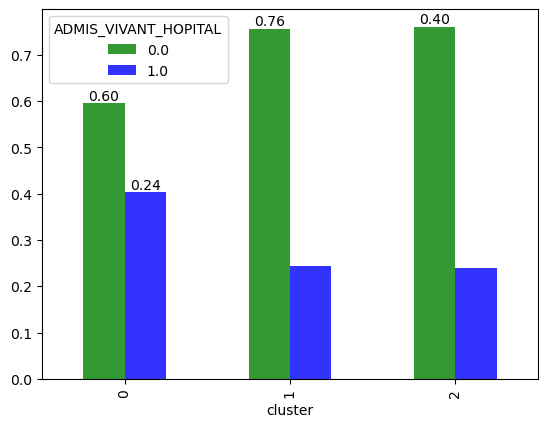

In [23]:
# Calculer les statistiques descriptives pour chaque groupe
clus_vivnt_hop = df_clusters.groupby("cluster")["ADMIS_VIVANT_HOPITAL"].value_counts(normalize=True)

# Convertisser l'objet pandas en un dataframe pour faciliter la manipulation
df_stats = clus_vivnt_hop.unstack().fillna(0)

# Tracer le graphique
ax = df_stats.plot(kind="bar", color=["green", "blue"], alpha=0.8)

# Ajouter les proportions exactes sur les barres
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    width, height = patch.get_width(), patch.get_height()
    label = "{:.2f}".format(df_stats.iloc[:, i // 2].values[i % 2])
    ax.text(x + width/2, y + height*1.01, label, ha="center")

# Personnaliser les étiquettes et la légende
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
ax.set_xticklabels(["Cluster 1", "Cluster 2", "Cluster 3"], rotation=0)
ax.legend(["Décès avant arrivée à l'hôpital", "Admis vivant à l'hôpital"])

plt.show()

In [24]:
import statsmodels.api as sm


X = df_clusters[['cluster', 'AGE']]
Y = df_clusters['DECES']

# Ajouter une colonne constante pour calculer l'interception
X = sm.add_constant(X)

# Créer le modèle de régression linéaire multiple
model = sm.OLS(Y, X).fit()

# Afficher les résultats de la régression
print(model.summary())

# Récupérer les coefficients et les erreurs standards
coefficients = np.round(model.coef, 2)
se = np.round(np.sqrt(np.diag(model.scale * np.linalg.inv(model.X.T @ model.X))), 2)

# Créer un dictionnaire avec les coefficients, les écart-types et les p-values
results_dict = {"Coefficient": model.params.values,
                "Ecart-type": model.bse.values,
                "P-value": model.pvalues.values}

# Convertir le dictionnaire en dataframe
results_df = pd.DataFrame(data=results_dict, index=model.params.index)

# Exporter le dataframe en CSV
results_df.to_csv("ols.csv", sep=",", index_label="Variables")

                            OLS Regression Results                            
Dep. Variable:                  DECES   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     21.21
Date:                Fri, 26 May 2023   Prob (F-statistic):           6.74e-10
Time:                        12:14:26   Log-Likelihood:                -1221.4
No. Observations:                4706   AIC:                             2449.
Df Residuals:                    4703   BIC:                             2468.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8673      0.022     39.462      0.0

AttributeError: 'OLSResults' object has no attribute 'coef'